In [1]:
import numpy as np
import cv2
import os
import re
from pprint import pprint
from PIL import Image

In [2]:
import sys
sys.path.append("..")

In [3]:
from pdf_utils import converter
from pdf_utils.pdf_handler import Pdf
from pdf_utils.annotated_pdf import AnnotatedPdf

# Create a pdf object

* A `Pdf` object is associated to one pdf file.

In [4]:
pdf = Pdf("../tests/data_git/example.pdf")

In [5]:
pdf.number_of_pages

2

In [6]:
# width and height of a page, in points
pdf.get_width_height(0)

(595, 841)

## Extracting images

* Let's see the first page as an image, rendered with `dpi=30`

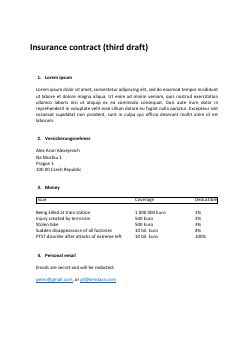

In [7]:
pdf.page_image(0, dpi=30, recompute=True)

* Create higher dpi image and see some detail

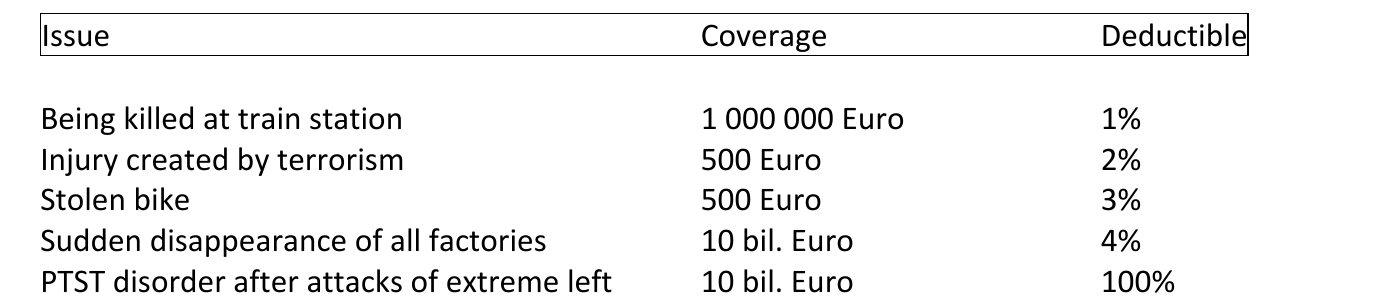

In [8]:
pdf.page_image(0, dpi=200, recompute=True).crop((200, 1300, 1600, 1600))

## Extracting text

In [9]:
text = pdf.layout_text
# create a list of strings, one per page
# '\f' is an invisible end-of-page char
pages = text.strip("\f").split("\f")
len(pages)

2

In [10]:
# print random part of first pages
print(pages[0][615:1130])


 Issue                                             Coverage                      Deductible

 Being killed at train station                     1 000 000 Euro                1%
 Injury created by terrorism                       500 Euro                      2%
 Stolen bike                                       500 Euro                      3%
 Sudden disappearance of all factories             10 bil. Euro                  4%
 PTST disorder after attacks of extreme left       10 bil. Euro                  100%


* We can also extract a html object with more structure
* The `text_with_bb` method returns the root of a html tree containing pages, lines, and words

In [11]:
#subprocess.check_output(["pdftotext",  "-bbox-layout",  "-f", "0",  "-l", "1", "../tests/data_git/example.pdf", "-"])
words = pdf.get_pages()[0]

In [12]:
w = words[123]
text, bounding_box = w.text, Pdf.get_bounding_box_of_elem(w)
print(f"word as string: '{text}'")
print(f"bounding box of the word: {bounding_box}")

word as string: 'Euro'
bounding box of the word: <Rectangle(x_min=345.253, y_min=517.8346, x_max=367.9378, y_max=532.4866)>


* Let's highlight this 123th word in the picture.
* For this, we first need to convert the bounding box from 'point'-coordinates into 'pixel'-coordinates

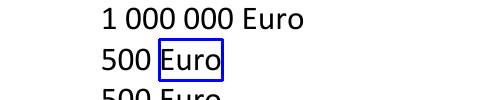

In [13]:
image_bb = converter.pdf_box_to_image_box(
    bounding_box, *pdf.get_width_height(0), *pdf.page_image(0, dpi=200, recompute=True).size)

image_with_enclosed_euro = cv2.rectangle(
    np.array(pdf.page_image(0)), 
    (image_bb.x_min, image_bb.y_min), 
    (image_bb.x_max, image_bb.y_max), 
    color=(0, 0, 255), thickness=2)

Image.fromarray(image_with_enclosed_euro[1400:1500, 800: 1300])

## Adding digital content

* If the pdf is only composed of images and has no digital content, we can do ocr and add the digital content
* The method is `recreate_digital_content`. If the initial pdf already has some digital content, it will be thrown away and recreated from images

In [14]:
pdf.recreate_digital_content(output_pdf="tmp.pdf")

* Check the file. Digital content is not that nice as before, but still reasonable

In [15]:
# ! open tmp.pdf

In [16]:
# cleanup
os.remove("tmp.pdf")

# Annotations in Pdf

* Annotations of words or objects in pdf are supported by many pdf readers, our favorite is the free [Foxit Reader](https://www.foxitsoftware.com/pdf-reader/)
* Example annotations can be found in the `example_annotated.pdf` file. We use 3 types of annotations:
  * rectangle,
  * note, and
  * oval.
* To fetch and digitalize annotations, we use a subclass `AnnotatedPdf` of `Pdf`.

In [17]:
annotated_pdf_path = "../tests/data_git/example_annotated.pdf"
annotated_pdf = AnnotatedPdf(annotated_pdf_path)

* Pls open the annotated pdf in a pdf browser

In [18]:
! open $annotated_pdf_path

### Accessing raw annotations, such as extracted from pdf.

* First annotation if of type 'note'

In [19]:
annotated_pdf.raw_annotations[0].as_dict

{'page': 0,
 'type': 'note',
 'box': {'x_min': 87.585,
  'y_min': 45.573999999999955,
  'x_max': 107.585,
  'y_max': 65.57399999999996},
 'label': None,
 'who_annotated': 'peter',
 'text_content': 'Daniel, include also the remaining 133 pages in the pdf!!!!'}

* Next one is of type 'rectangle'.

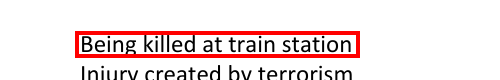

In [20]:
annotated_pdf.page_image(0).crop((100, 1020, 600, 1100))

* The pdf text "Being killed at train station" is annotated as "risk"

In [21]:
annotated_pdf.raw_annotations[1].as_dict

{'page': 0,
 'type': 'rectangle',
 'box': {'x_min': 83.459, 'y_min': 504.121, 'x_max': 221.118, 'y_max': 518.0},
 'label': None,
 'who_annotated': 'peter',
 'text_content': 'risk'}

### Accessing 'rectangle'-annotations with text.

* In the above rectangle annotation, we only obtained a bounding box, but couldn't see what is inside (the pdf)
* To see the textual content inside the bounding box, we use the `enriched_annotations` property

In [22]:
enriched_ann = annotated_pdf.enriched_annotations[0]
enriched_ann

{'annotation': {"page": 0, "type": "rectangle", "box": {"x_min": 83.459, "y_min": 504.121, "x_max": 221.118, "y_max": 518.0}, "label": null, "who_annotated": "peter", "text_content": "risk"},
 'words': [{'word': <Element word at 0x7f88868bc8f0>,
   'score': 0.9367867867867875},
  {'word': <Element word at 0x7f88868bc950>, 'score': 0.9367867867867874},
  {'word': <Element word at 0x7f88868bc9b0>, 'score': 0.9367867867867872},
  {'word': <Element word at 0x7f88868bca10>, 'score': 0.9367867867867873},
  {'word': <Element word at 0x7f88868bca70>, 'score': 0.9367867867867873}]}

* This is a dictionary with two keys:
  * 'annotation' -- this is the raw annotation as above
  * 'words' -- the value is a collection of html elements corresponding to words
  * the score shows how much of the word-bounding box overlaps the annotation bounding box
  * These html objects can be easily converted to strings:

In [23]:
[w["word"].text for w in enriched_ann["words"]]

['Being', 'killed', 'at', 'train', 'station']

### Seeing annotated words in context

* Main method for this is `get_flows_with_annotations`
* The structure of the hmtl tree roughly like this:\
    `page > flow > block > line > word`
* We work on the level of 'flows'. Each annotated flow contains:
  * 'words': list of all words in current flow
  * 'page': page number (starting from 0)
  * 'annotated_indices': a dictionary {'text_from_annotator': \[list of indices of words\]}
Here is the fourth flow:

In [24]:
annotated_pdf._page_to_page_idx

{<Element page at 0x7f88876762f0>: 0, <Element page at 0x7f8887665fb0>: 1}

In [25]:
flow_id_3 = annotated_pdf.get_flows_with_annotations()[3]
flow_id_3

{'words': ['Being',
  'killed',
  'at',
  'train',
  'station',
  'Injury',
  'created',
  'by',
  'terrorism',
  'Stolen',
  'bike',
  'Sudden',
  'disappearance',
  'of',
  'all',
  'factories',
  'PTST',
  'disorder',
  'after',
  'attacks',
  'of',
  'extreme',
  'left'],
 'page': 0,
 'annotated_indices': defaultdict(list, {'risk': [0, 1, 2, 3, 4]})}

In [26]:
# what is annotated?
' '.join(flow_id_3['words'][i] for i in flow_id_3['annotated_indices']['risk'])

'Being killed at train station'

* This can be useful for training ML models

In [27]:
# binary feature, closeness of word 'bike' near to a 'risk'-annotation
int("bike" in flow_id_3["words"])

1

In [28]:
# binary feature, closeness of word 'airplane' near to a 'risk'-annotation
int("airplane" in flow_id_3["words"])

0

In [29]:
bike_span = re.search(r"bike", ' '.join(flow_id_3["words"])).span()
bike_span

(65, 69)

In [30]:
print("match of the 'bike' regex in our flow:")
bike_word_indices = converter.get_indices_of_words(flow_id_3["words"], bike_span)
bike_word_indices

match of the 'bike' regex in our flow:


{'full_words': [10], 'partial_words': []}

In [31]:
print("word distance of word 'bike' from our risk-annotation:")
min(bike_word_indices['full_words']) - max(flow_id_3["annotated_indices"]["risk"])

word distance of word 'bike' from our risk-annotation:


6

### Cleaning pdf from annotations 

* the method `remove_annotations_and_save` cleans the pdf from all annotations

In [32]:
annotated_pdf.remove_annotations_and_save("clean.pdf")

annotated pdf


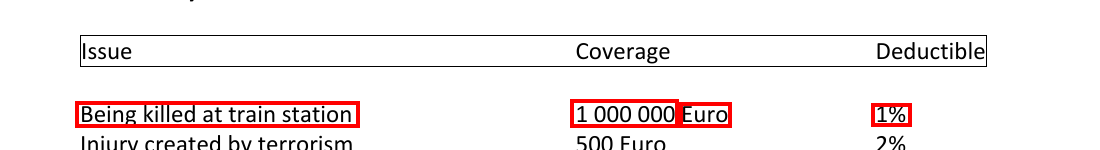

In [33]:
print("annotated pdf")
example_crop = (100, 950, 1200, 1100)
annotated_pdf.page_image(0, dpi=150, recompute=True).crop(example_crop)

removed annotations


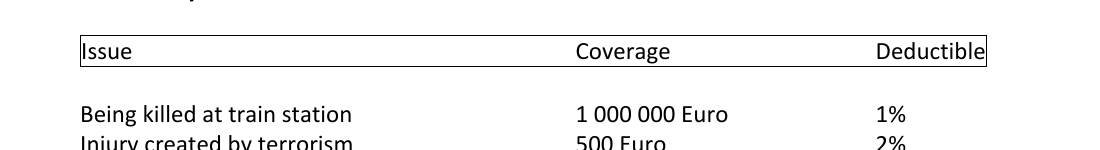

In [34]:
print("removed annotations")
Pdf("clean.pdf").page_image(0, dpi=150, recompute=True).crop(example_crop)

In [35]:
os.remove("clean.pdf")